In [1]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [4]:
"""
Topic: use the customer retail data to predict the next purchase day of certain customer
it has huge market/practical values as different next purchase day can lead to 
different promotion strategy

Steps:
1. Data wrangling
2. Feature engineering
3. Machine learning model
4. Multi classification model
5. Parameter tuning

"""

'\nTopic: use the customer retail data to predict the next purchase day of certain customer\nit has huge market/practical values as different next purchase day can lead to \ndifferent promotion strategy\n\nSteps:\n1. Data wrangling\n2. Feature engineering\n3. Machine learning model\n4. Multi classification model\n5. Parameter tuning\n\n'

In [5]:
"""
Select the historical period:
1. select a cutoff date
2. choose the 6 month historical data before cutoff 
3. choose the 3 month after cutoff to verify the prediction
"""


'\nSelect the historical period:\n1. select a cutoff date\n2. choose the 6 month historical data before cutoff \n3. choose the 3 month after cutoff to verify the prediction\n'

## Data Wrangling

In [29]:
tx_data = pd.read_csv('C:/Users/lizil/Dropbox/Job/Kaggle/Retail/kaggle_retail/OnlineRetail.csv',encoding= 'unicode_escape')
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])
tx_uk = tx_data.query("Country=='United Kingdom'").reset_index(drop=True)

In [121]:
tx_6m = tx_uk[(tx_uk.InvoiceDate < date(2011,9,1)) & (tx_uk.InvoiceDate >= date(2011,3,1))].reset_index(drop=True)
tx_next = tx_uk[(tx_uk.InvoiceDate >= date(2011,9,1)) & (tx_uk.InvoiceDate < date(2011,12,1))].reset_index(drop=True)

In [122]:
tx_user = pd.DataFrame(tx_6m['CustomerID'].unique())
tx_user.columns = ['CustomerID']

In [123]:
tx_next_first_purchase = tx_next.groupby('CustomerID').InvoiceDate.min().reset_index()
tx_next_first_purchase.columns = ['CustomerID','MinPurchaseDate']

In [124]:
tx_next_first_purchase.head(10)

,CustomerID,MinPurchaseDate
0,12747.0,2011-10-04 08:26:00
1,12748.0,2011-09-02 10:49:00
2,12749.0,2011-11-17 12:05:00
3,12820.0,2011-09-26 11:49:00
4,12822.0,2011-09-13 13:46:00
5,12823.0,2011-09-26 07:35:00
6,12824.0,2011-10-11 12:49:00
7,12826.0,2011-09-29 10:55:00
8,12827.0,2011-10-26 15:44:00
9,12828.0,2011-09-01 17:14:00


In [125]:
tx_last_purchase = tx_6m.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_last_purchase.columns = ['CustomerID','MaxPurchaseDate']

In [126]:
tx_purchase_dates = pd.merge(tx_last_purchase,tx_next_first_purchase,on='CustomerID',how='left')


In [127]:
tx_purchase_dates['NextPurchaseDay'] = (tx_purchase_dates['MinPurchaseDate'] - tx_purchase_dates['MaxPurchaseDate']).dt.days

In [128]:
tx_user = pd.merge(tx_user, tx_purchase_dates[['CustomerID','NextPurchaseDay']],on='CustomerID',how='left')

In [129]:
tx_user = tx_user.fillna(999)
tx_user.head()

,CustomerID,NextPurchaseDay
0,14620.0,999.0
1,14740.0,999.0
2,13880.0,57.0
3,16462.0,111.0
4,17068.0,16.0


## Feature Engineering

### Recency

In [130]:
tx_max_purchase = tx_6m.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

#find the recency in days and add it to tx_user
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')

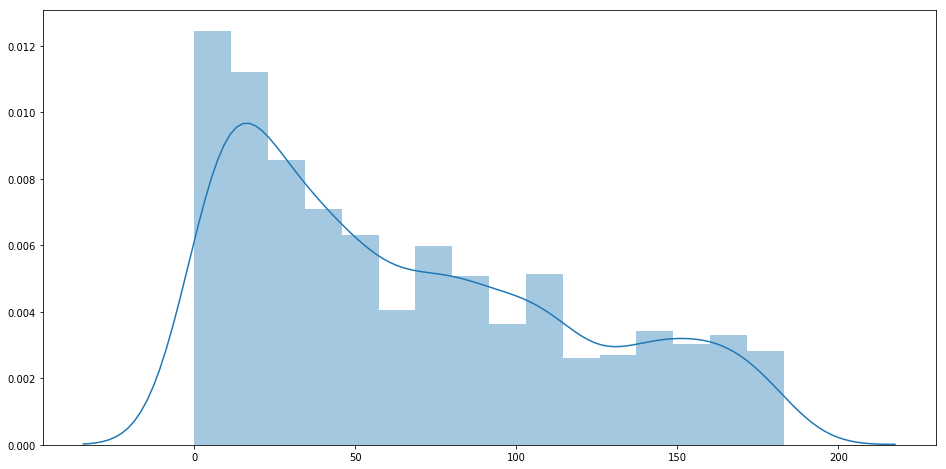

In [131]:
fig, ax = plt.subplots(figsize = (16,8))
sns.distplot(tx_user[['Recency']])
plt.show()

In [132]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

In [133]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [134]:
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

In [135]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,449.0,154.665924,15.863669,126.0,141.0,154.0,167.0,183.0
1,573.0,97.125654,13.976688,75.0,85.0,98.0,110.0,125.0
2,665.0,50.935338,12.413812,33.0,40.0,49.0,62.0,73.0
3,881.0,14.049943,8.883066,0.0,7.0,13.0,21.0,31.0


### Frequency

In [136]:
tx_frequency = tx_6m.groupby('CustomerID').InvoiceDate.count().reset_index()
tx_frequency.columns = ['CustomerID','Frequency']

In [137]:
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')

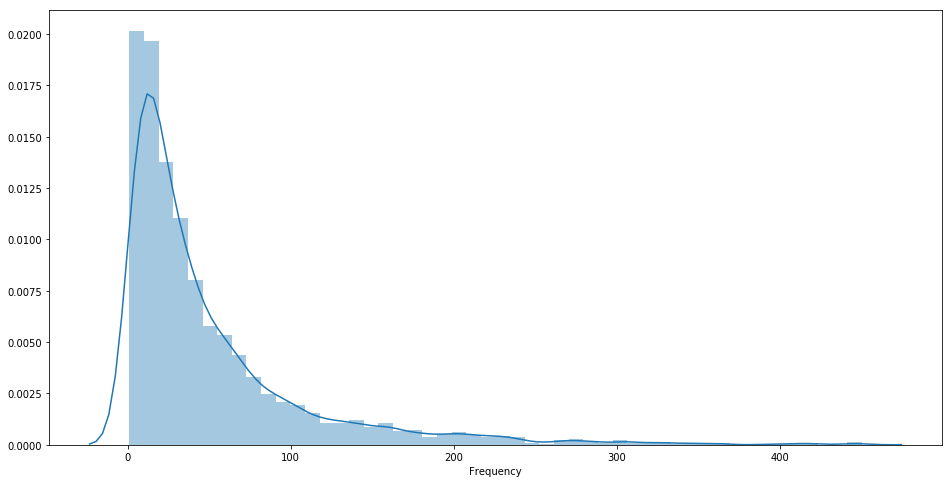

In [138]:
fig, ax = plt.subplots(figsize = (16,8))
sns.distplot(tx_user[tx_user['Frequency']<500]['Frequency'])
plt.show()

In [139]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

In [140]:
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)
tx_user.groupby('FrequencyCluster')['Frequency'].describe()


,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,2239.0,31.732023,26.036899,1.0,11.00,23.0,46.00,107.0
1,312.0,182.439103,70.488211,108.0,130.00,160.0,212.25,450.0
2,16.0,766.062500,260.797103,510.0,555.75,646.5,936.50,1251.0
3,1.0,3546.000000,NaN,3546.0,3546.00,3546.0,3546.00,3546.0


### Monetary

In [141]:
tx_6m['Revenue'] = tx_6m['UnitPrice'] * tx_6m['Quantity']
tx_revenue = tx_6m.groupby('CustomerID').Revenue.sum().reset_index()

In [142]:
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')


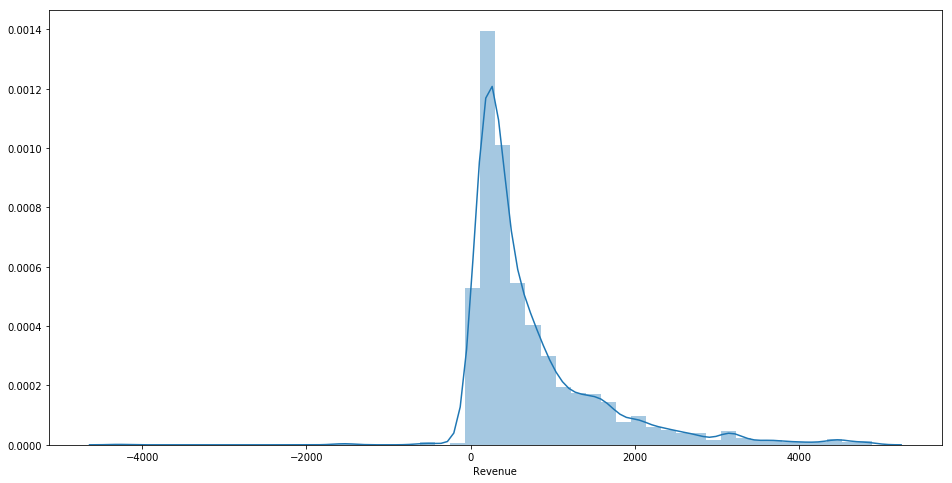

In [143]:
fig, ax = plt.subplots(figsize = (16,8))
sns.distplot(tx_user[tx_user['Revenue']<5000]['Revenue'])
plt.show()

In [144]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])

In [145]:
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)
tx_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,2415.0,635.360862,618.311128,-4287.63,212.1850,406.480,866.6600,2906.31
1,136.0,5237.716699,2617.500448,2952.40,3282.0950,4419.950,5634.9350,13760.87
2,15.0,24656.247333,7716.951663,15847.56,17484.2400,23196.350,31386.6450,37934.22
3,2.0,76665.615000,17370.382136,64382.90,70524.2575,76665.615,82806.9725,88948.33


### Overall Score

In [146]:
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']

In [147]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value'

In [148]:
tx_user.groupby('OverallScore')['Recency','Frequency','Revenue'].agg(['count','mean'])

Recency             Frequency              Revenue              
               count        mean     count         mean   count          mean
OverallScore                                                                 
0                444  154.750000       444    19.412162     444    289.172973
1                555   97.965766       555    27.293694     555    445.157207
2                606   52.656766       606    37.529703     606    576.943186
3                681   18.450808       681    52.588840     681    904.059517
4                184   15.445652       184   160.429348     184   2526.410000
5                 76    9.815789        76   214.855263      76   6653.958947
6                 16    8.812500        16   568.562500      16  13181.453125
7                  5   12.200000         5   591.600000       5  46209.390000
8                  1    3.000000         1  3546.000000       1  16643.220000

In [149]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value'

In [150]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")


In [151]:
tx_graph.head(10)

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,14620.0,999.0,104,1,30,0,393.28,0,1,Low-Value
1,14740.0,999.0,91,1,93,0,1423.21,0,1,Low-Value
2,16462.0,111.0,85,1,2,0,68.00,0,1,Low-Value
3,15676.0,178.0,113,1,63,0,877.40,0,1,Low-Value
4,15092.0,999.0,115,1,26,0,457.81,0,1,Low-Value
5,17027.0,100.0,79,1,45,0,183.50,0,1,Low-Value
6,15953.0,146.0,111,1,14,0,413.95,0,1,Low-Value
7,16389.0,127.0,105,1,16,0,670.17,0,1,Low-Value
8,17770.0,999.0,98,1,38,0,1143.27,0,1,Low-Value
9,15643.0,999.0,79,1,36,0,647.40,0,1,Low-Value


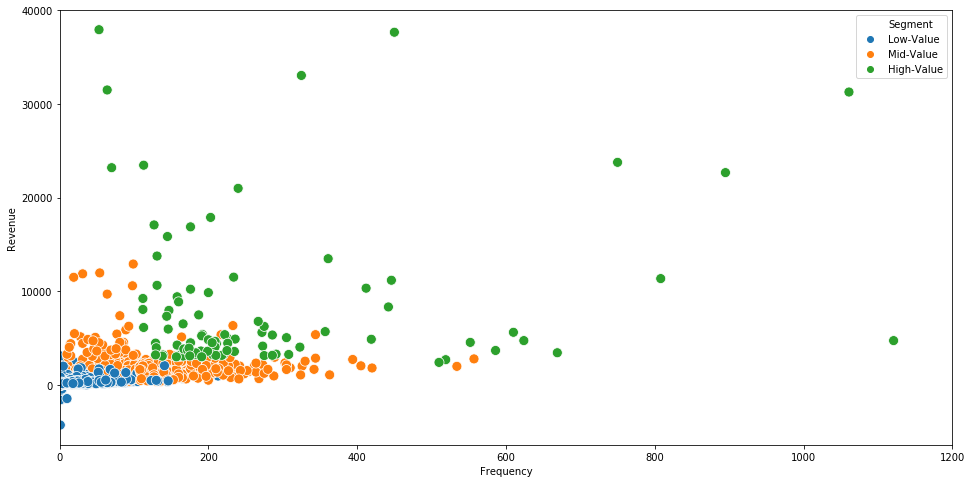

In [152]:
fig, ax = plt.subplots(figsize = (16,8))
sns.scatterplot(x='Frequency', y='Revenue', hue = 'Segment', data = tx_graph, s= 100)
ax.set_xlim(0,1200)
plt.show()

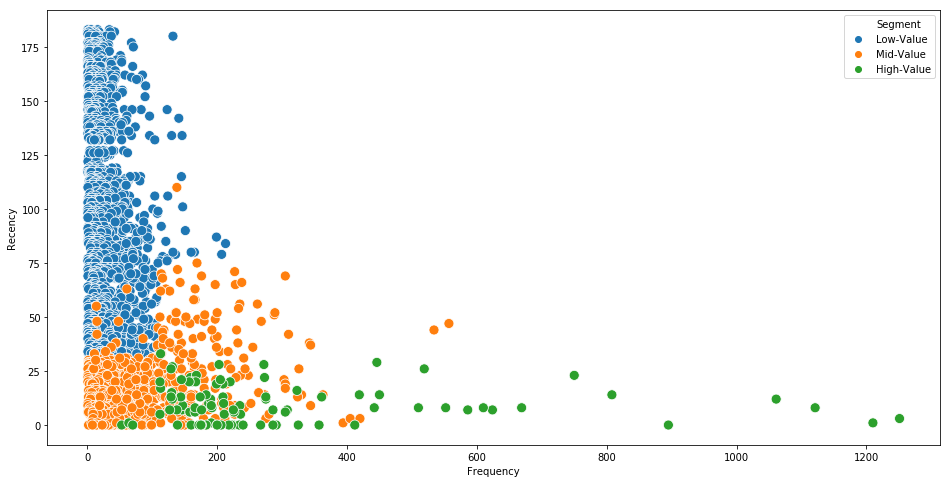

In [153]:
fig, ax = plt.subplots(figsize = (16,8))
sns.scatterplot(x='Frequency', y='Recency', hue = 'Segment', data = tx_graph, s= 100)

plt.show()

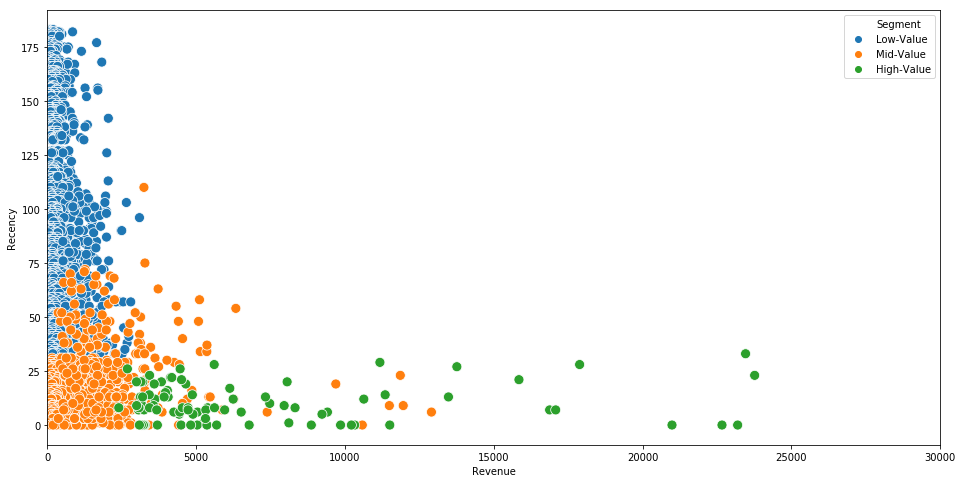

In [154]:
fig, ax = plt.subplots(figsize = (16,8))
sns.scatterplot(x='Revenue', y='Recency', hue = 'Segment', data = tx_graph, s= 100)
ax.set_xlim(0,30000)
plt.show()

### Adjacent Purchases Intervals

In [155]:
tx_day_order = tx_6m[['CustomerID','InvoiceDate']]

In [156]:
tx_day_order['InvoiceDay'] = tx_6m['InvoiceDate'].dt.date

In [157]:
tx_day_order = tx_day_order.sort_values(['CustomerID','InvoiceDate'])

In [158]:
## making sure there were no duplicated transactions on same day for same customer ID
tx_day_order = tx_day_order.drop_duplicates(subset=['CustomerID','InvoiceDay'],keep='first')

In [159]:
## use the shift function to pivot the purchase date into different columns
tx_day_order['PrevInvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(1)
tx_day_order['T2InvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(2)
tx_day_order['T3InvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(3)

In [160]:
tx_day_order.head()

,CustomerID,InvoiceDate,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate
649,12747.0,2011-03-01 14:53:00,2011-03-01,NaN,NaN,NaN
65091,12747.0,2011-05-05 15:31:00,2011-05-05,2011-03-01,NaN,NaN
90473,12747.0,2011-05-25 09:57:00,2011-05-25,2011-05-05,2011-03-01,NaN
124699,12747.0,2011-06-28 10:06:00,2011-06-28,2011-05-25,2011-05-05,2011-03-01
184410,12747.0,2011-08-22 10:38:00,2011-08-22,2011-06-28,2011-05-25,2011-05-05


In [161]:
tx_day_order['DayDiff'] = (tx_day_order['InvoiceDay'] - tx_day_order['PrevInvoiceDate']).dt.days
tx_day_order['DayDiff2'] = (tx_day_order['InvoiceDay'] - tx_day_order['T2InvoiceDate']).dt.days
tx_day_order['DayDiff3'] = (tx_day_order['InvoiceDay'] - tx_day_order['T3InvoiceDate']).dt.days

In [162]:

tx_day_order.head(10)

,CustomerID,InvoiceDate,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate,DayDiff,DayDiff2,DayDiff3
649,12747.0,2011-03-01 14:53:00,2011-03-01,NaN,NaN,NaN,NaN,NaN,NaN
65091,12747.0,2011-05-05 15:31:00,2011-05-05,2011-03-01,NaN,NaN,65.0,NaN,NaN
90473,12747.0,2011-05-25 09:57:00,2011-05-25,2011-05-05,2011-03-01,NaN,20.0,85.0,NaN
124699,12747.0,2011-06-28 10:06:00,2011-06-28,2011-05-25,2011-05-05,2011-03-01,34.0,54.0,119.0
184410,12747.0,2011-08-22 10:38:00,2011-08-22,2011-06-28,2011-05-25,2011-05-05,55.0,89.0,109.0
7326,12748.0,2011-03-08 12:30:00,2011-03-08,NaN,NaN,NaN,NaN,NaN,NaN
10606,12748.0,2011-03-11 11:37:00,2011-03-11,2011-03-08,NaN,NaN,3.0,NaN,NaN
17545,12748.0,2011-03-18 13:08:00,2011-03-18,2011-03-11,2011-03-08,NaN,7.0,10.0,NaN
20123,12748.0,2011-03-21 15:40:00,2011-03-21,2011-03-18,2011-03-11,2011-03-08,3.0,10.0,13.0
24764,12748.0,2011-03-24 13:37:00,2011-03-24,2011-03-21,2011-03-18,2011-03-11,3.0,6.0,13.0


In [163]:
tx_day_diff = tx_day_order.groupby('CustomerID').agg({'DayDiff': ['mean','std']}).reset_index()

In [164]:
tx_day_diff.columns = ['CustomerID', 'DayDiffMean','DayDiffStd']


In [165]:
tx_day_order_last = tx_day_order.drop_duplicates(subset=['CustomerID'],keep='last')

In [166]:
tx_day_order_last=pd.merge(tx_day_order_last,tx_day_diff,on=['CustomerID'],how='left')

In [167]:
tx_day_order_last = tx_day_order_last.dropna()

In [168]:
tx_user = pd.merge(tx_user, tx_day_order_last[['CustomerID','DayDiff','DayDiff2','DayDiff3','DayDiffMean','DayDiffStd']], on='CustomerID')

In [169]:
tx_user.head(10)

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd
0,14740.0,999.0,91,1,93,0,1423.21,0,1,Low-Value,6.0,34.0,92.0,30.666667,26.102363
1,17770.0,999.0,98,1,38,0,1143.27,0,1,Low-Value,14.0,77.0,84.0,28.000000,30.512293
2,15643.0,999.0,79,1,36,0,647.40,0,1,Low-Value,5.0,6.0,12.0,25.750000,43.553607
3,14231.0,999.0,79,1,35,0,513.11,0,1,Low-Value,4.0,53.0,103.0,34.333333,26.274195
4,18218.0,999.0,106,1,24,0,626.38,0,1,Low-Value,5.0,61.0,75.0,25.000000,27.221315
5,13476.0,999.0,78,1,61,0,1092.77,0,1,Low-Value,7.0,96.0,103.0,34.333333,47.342722
6,15696.0,133.0,113,1,61,0,773.34,0,1,Low-Value,5.0,7.0,39.0,13.000000,13.656500
7,13092.0,141.0,111,1,15,0,236.30,0,1,Low-Value,16.0,50.0,66.0,22.000000,10.392305
8,18183.0,999.0,117,1,44,0,600.52,0,1,Low-Value,9.0,43.0,49.0,11.200000,13.065221
9,16359.0,81.0,75,1,36,0,666.43,0,1,Low-Value,15.0,38.0,67.0,24.500000,7.187953


In [170]:

len(tx_user)

623

In [171]:
tx_class = tx_user.copy()
tx_class = pd.get_dummies(tx_class)

## Model Selection

In [172]:
### categorize the target variable preparing for next step
tx_user.NextPurchaseDay.describe()

count    623.000000
mean     176.390048
std      326.482713
min        0.000000
25%       24.500000
50%       47.000000
75%       87.000000
max      999.000000
Name: NextPurchaseDay, dtype: float64

In [173]:
tx_class['NextPurchaseDayRange'] = 2
tx_class.loc[tx_class.NextPurchaseDay>20,'NextPurchaseDayRange'] = 1
tx_class.loc[tx_class.NextPurchaseDay>50,'NextPurchaseDayRange'] = 0

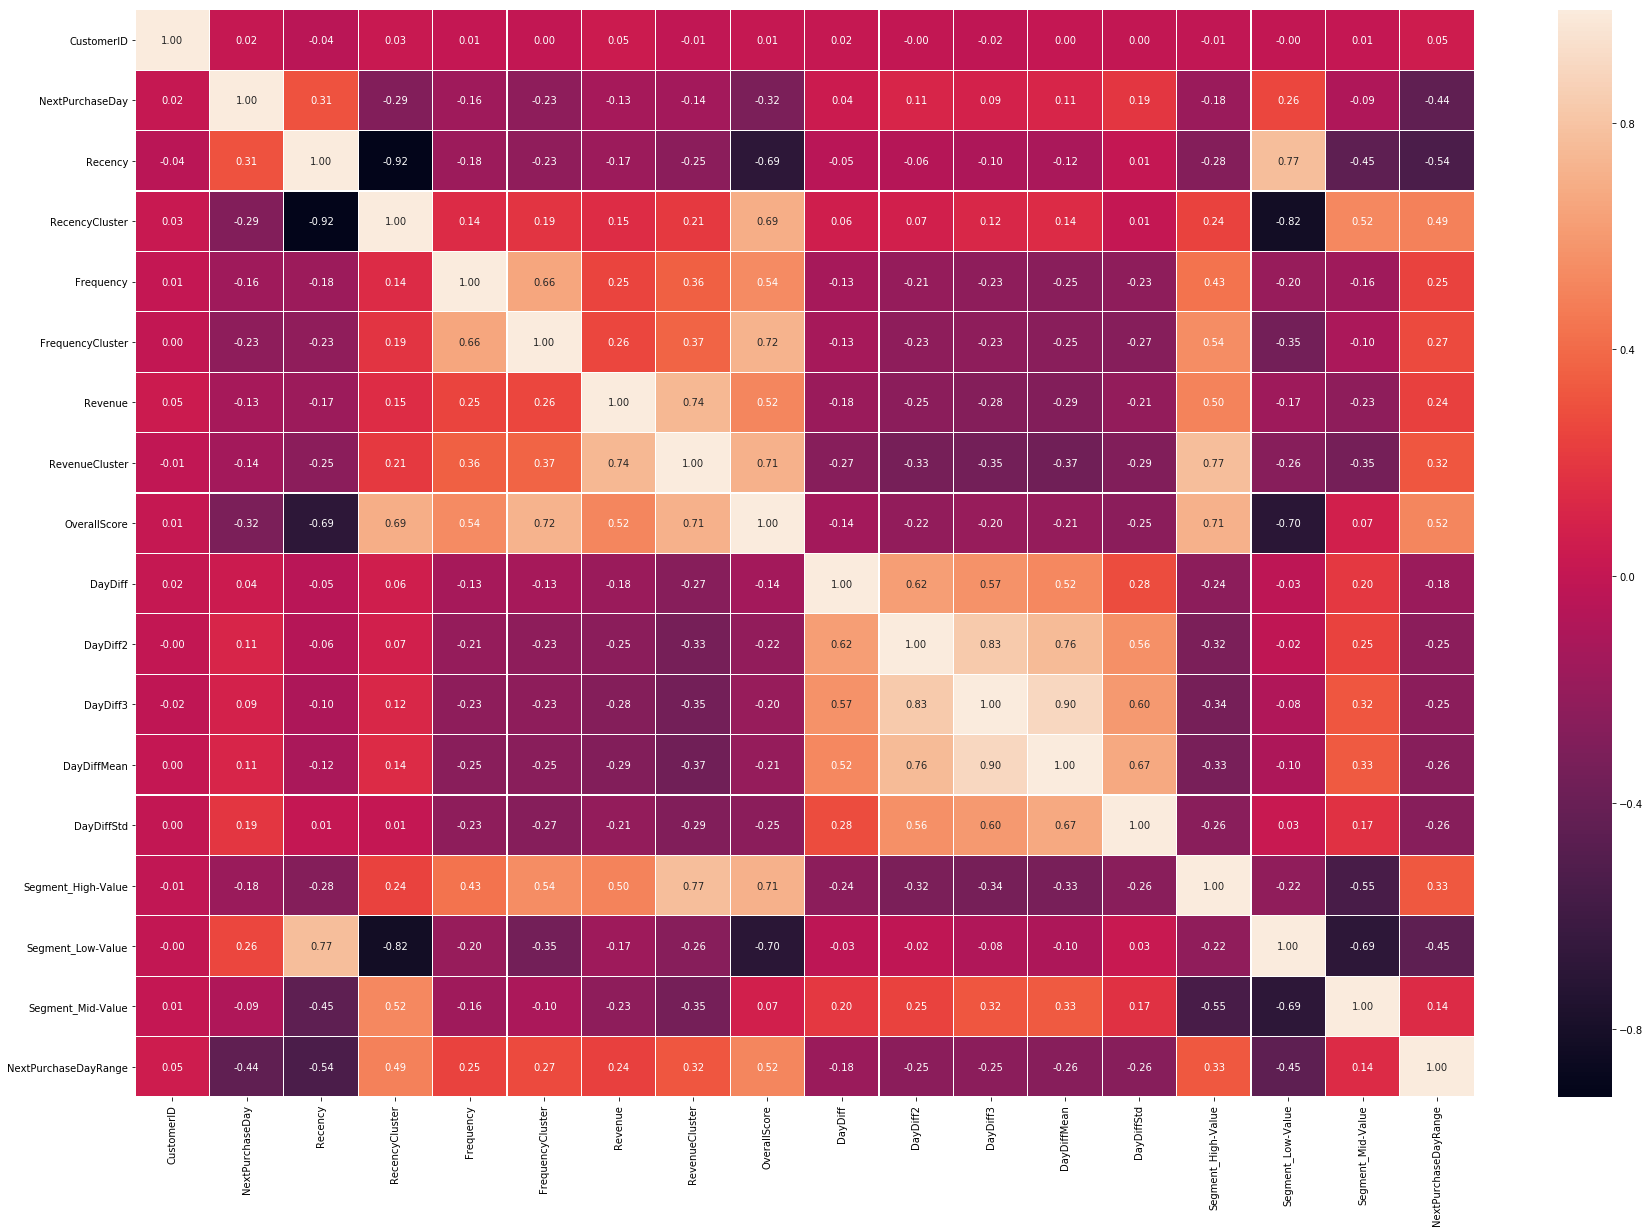

In [174]:
corr = tx_class[tx_class.columns].corr()
plt.figure(figsize = (30,20))
sns.heatmap(corr, annot = True, linewidths=0.2, fmt=".2f")

In [175]:
X, y = tx_class.drop('NextPurchaseDayRange',axis=1), tx_class.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

In [176]:
### Choose a model bucket. Use nflod on the training data to choose the best performed one
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))

In [177]:
for name,model in models:
    kfold = KFold(n_splits=3, random_state=22)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)

LR [0.93975904 0.90963855 0.92168675]
NB [0.8313253  0.8373494  0.84337349]
RF [0.96385542 0.98795181 0.98795181]
SVC [0.51204819 0.45783133 0.48192771]
Dtree [1. 1. 1.]
XGB [1. 1. 1.]
KNN [0.48795181 0.53614458 0.47590361]


In [178]:
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 1.00
Accuracy of XGB classifier on test set: 1.00


In [179]:
y_pred = xgb_model.predict(X_test)

In [180]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        20

   micro avg       1.00      1.00      1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125



In [181]:
from sklearn.model_selection import GridSearchCV

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(), 
param_grid = param_test1, scoring='accuracy',n_jobs=-1,iid=False, cv=2)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 1}, 1.0)

In [182]:
xgb_model = xgb.XGBClassifier(max_depth=3, min_child_weight=5).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 1.00
Accuracy of XGB classifier on test set: 1.00


In [183]:
y_pred = xgb_model.predict(X_test)

In [184]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        20

   micro avg       1.00      1.00      1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125

